In [16]:
import time, os, copy, datetime, math, random, warnings
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from anndata import AnnData
import seaborn as sns
import infercnvpy as cnv
from marker_count2 import MarkerCount_GSA, show_summary, get_markers_major_type
from marker_count2 import get_markers_cell_type, get_markers_minor_type2, load_markers_all
import warnings

warnings.filterwarnings(action='ignore')
sc.settings.set_figure_params(figsize=(5, 5))

# HiCAT - Celltype Annotation for GSE154778 data (PAAD patients)

In [17]:
target_cell_types = ['T cell', 'B cell', 'Myeloid cell', 'Fibroblast', 'Mast cell',
                     'Epithelial cell', 'Endothelial cell', 'Granulocyte']
to_exclude = []

mkr_file = 'cell_markers_rndsystems_v5g.tsv'
    

h5ad_file = '/mnt/HDD1/Work_Paper/Singlecell_RNA/PreProcessed_GSE154778/GSE154778.h5ad'
folder_dir = os.path.dirname(h5ad_file)
basename = os.path.basename(h5ad_file)

adata = sc.read_h5ad(h5ad_file)
adata_t = adata.copy()
X1 = adata_t.to_df()

df_pred, summary = \
MarkerCount_GSA( X1, marker_file = mkr_file, log_transformed = False, 
                 Clustering_algo = 'lv', Clustering_resolution = 2, 
                 Clustering_base = 'pca', N_pca_components = 15, 
                 model = 'gmm', N_gmm_components = 10, ident_level = 3, 
                 minor_id_sep = True, Target_FPR = 0.05, pval_th = 0.05, 
                 pmaj = 0.8, pth_margin_mult = 4, pth_min = 0.2, 
                 min_logP_diff = 3, mkr_selector = '100000', 
                 rem_cmn_mkr = False, target_cell_types = target_cell_types, 
                 minor_types_to_exclude = to_exclude, 
                 N_neighbors_minor = 31, N_neighbors_subset = 11, 
                 pval_th2 = 1, cycling_cell = False, verbose = True )

adata_t.obs['cluster'] = df_pred['cluster']
adata_t.obs['cell_type_subset_pred'] = df_pred['cell_type_subset']
adata_t.obs['cell_type_minor_pred'] = df_pred['cell_type_minor']
adata_t.obs['cell_type_major_pred'] = df_pred['cell_type_major']

save_file = os.path.join(folder_dir,'Ann_'+basename)



MarkerCount_GSA running ..
PCA .. Clustering .. Nc = 39, Load markers ..  8 types. 
B cell,Endothelial cell,Epithelial cell,Fibroblast,Granulocyte,Mast cell,Myeloid cell,T cell
GSA .. Thresholds:
    Epithelial cell: 3.946, 1.887 >  1.89,  2.09 > 2736/2987
         Fibroblast: 6.008, 2.003 >  2.00,  3.00 > 1839/1976
             T cell: 4.825, 2.366 >  4.77,  2.04 > 112/272
          Mast cell: 3.081, 2.619 >  3.08,  1.18 > 27/56
             B cell: 2.586, 1.747 >  2.59,  1.48 > 14/29
       Myeloid cell: 5.588, 2.539 >  2.54,  2.20 > 989/1065
   Endothelial cell: 4.724, 2.172 >  2.17,  2.17 > 102/109
        Granulocyte: 3.006, 2.608 >  3.01,  1.15 > 17/45
P[Pv<Th] cutoff = 0.22(0.62) --> 0 cluster(s) among 39 excluded. 
Fitting GMM .. Num of unassigned cells: 0 among 7031
Thresholds:
    Epithelial cell: -24.81, -41.88 > Threshold: -68.53 > 3306/3306,  165/3264
         Fibroblast: -25.63, -38.94 > Threshold: -50.07 > 2090/2102,  105/3378
             T cell:   0.00, -54.14 > Thresh

... storing 'cluster' as categorical
... storing 'cell_type_subset_pred' as categorical
... storing 'cell_type_minor_pred' as categorical
... storing 'cell_type_major_pred' as categorical


Endothelial cell subset identification: Endothelial cell
Basophil subset identification: Basophil
Eosinophil subset identification: Eosinophil
Neutrophil subset identification: Neutrophil
Num of unassigned cells: 0 among 7031
MarkerCount_GSA done. (231)


# Assign cell to either "tumor" or "normal" using 'infercnvpy'
## See https://infercnvpy.readthedocs.io/en/latest/notebooks/tutorial_3k.html

In [213]:
sc.pp.log1p(adata_t)

/home/mlbi/anaconda3/envs/py38_/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:373: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [19]:
adata_t.obs['cell_type_major_pred'].unique()

['Epithelial cell', 'Fibroblast', 'T cell', 'Myeloid cell']
Categories (4, object): ['Epithelial cell', 'Fibroblast', 'Myeloid cell', 'T cell']

In [20]:
cnv.io.genomic_position_from_gtf('/mnt/HDD2/Ref_data/RefGenome_hs/GTF_for_InferCNV.gtf', adata_t, gtf_gene_id='gene_name', adata_gene_id=None, inplace=True)

INFO:root:Extracted GTF attributes: ['gene_id', 'gene_name']


## Solid tumors primarily originate from epithelial cells. Solid tumor refers to a tumor that arises from epithelial cells, which are the cells that line the surfaces of our body, such as the skin, organ linings, and mucous membranes.

In [21]:
cnv.tl.infercnv(adata_t, reference_key="cell_type_major_pred", reference_cat=["Fibroblast",'T cell','Myeloid cell'], window_size=250,)

  0%|          | 0/2 [00:00<?, ?it/s]

# UMAP of CNV profiles - group by major celltype

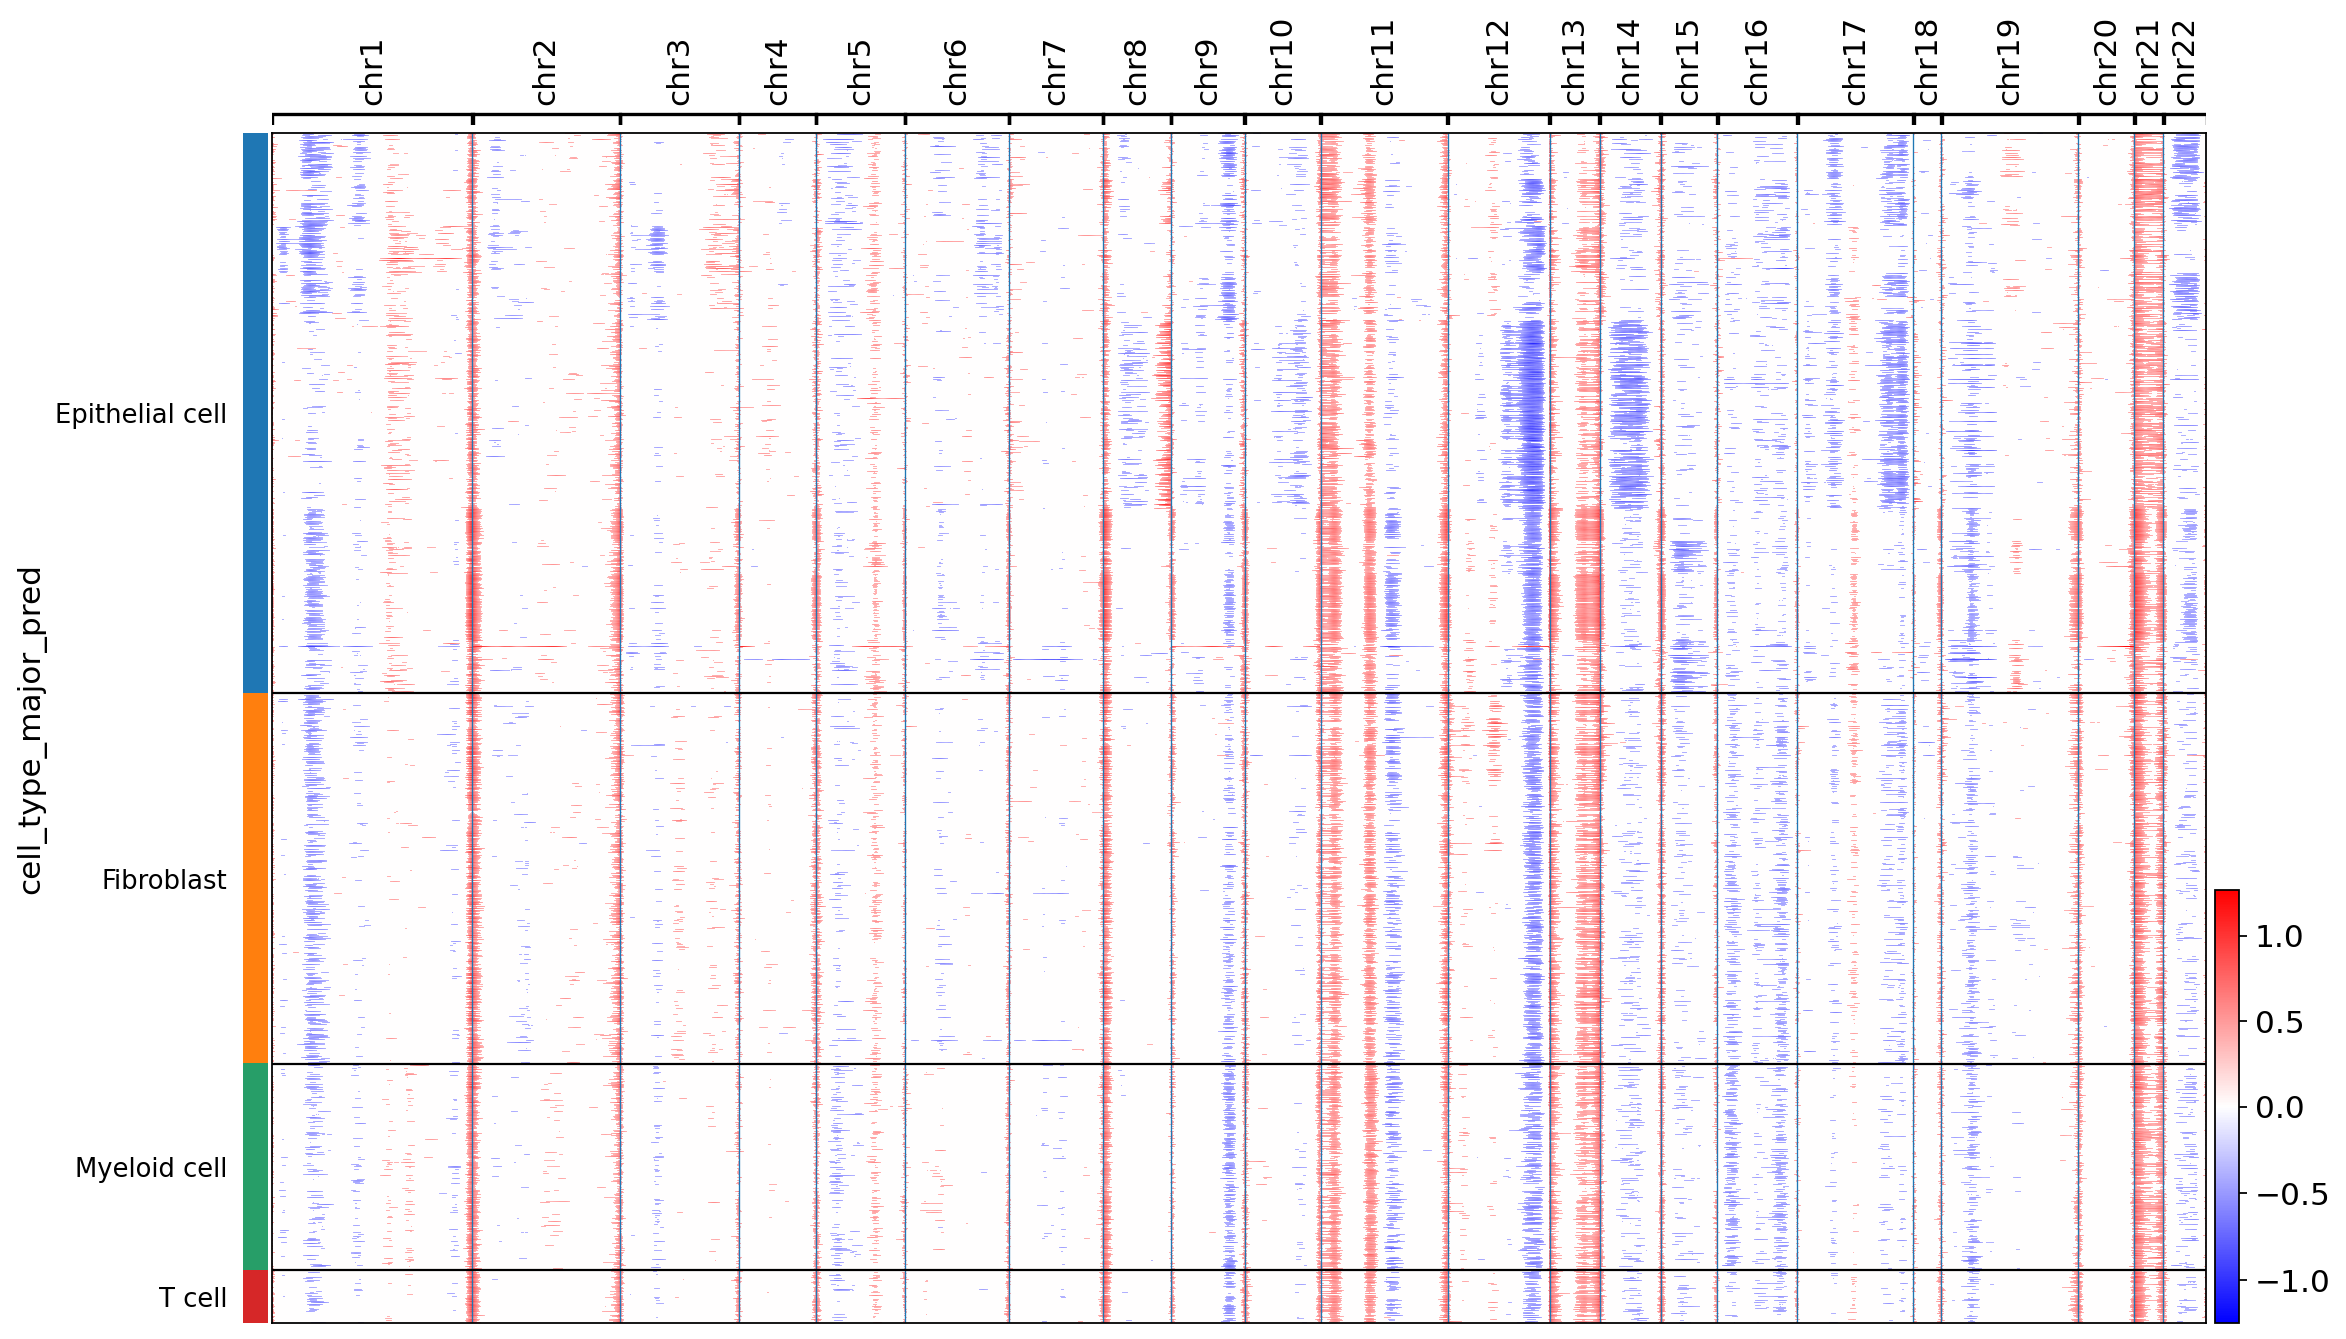

In [22]:
cnv.pl.chromosome_heatmap(adata_t, groupby="cell_type_major_pred")

# UMAP of CNV profiles - group by cnv leiden clustering

In [23]:
cnv.tl.pca(adata_t)
cnv.pp.neighbors(adata_t)
cnv.tl.leiden(adata_t, resolution = 0.5)

         Falling back to preprocessing with `sc.pp.pca` and default params.
categories: 0, 1, 2, etc.
var_group_labels: chr1, chr2, chr3, etc.


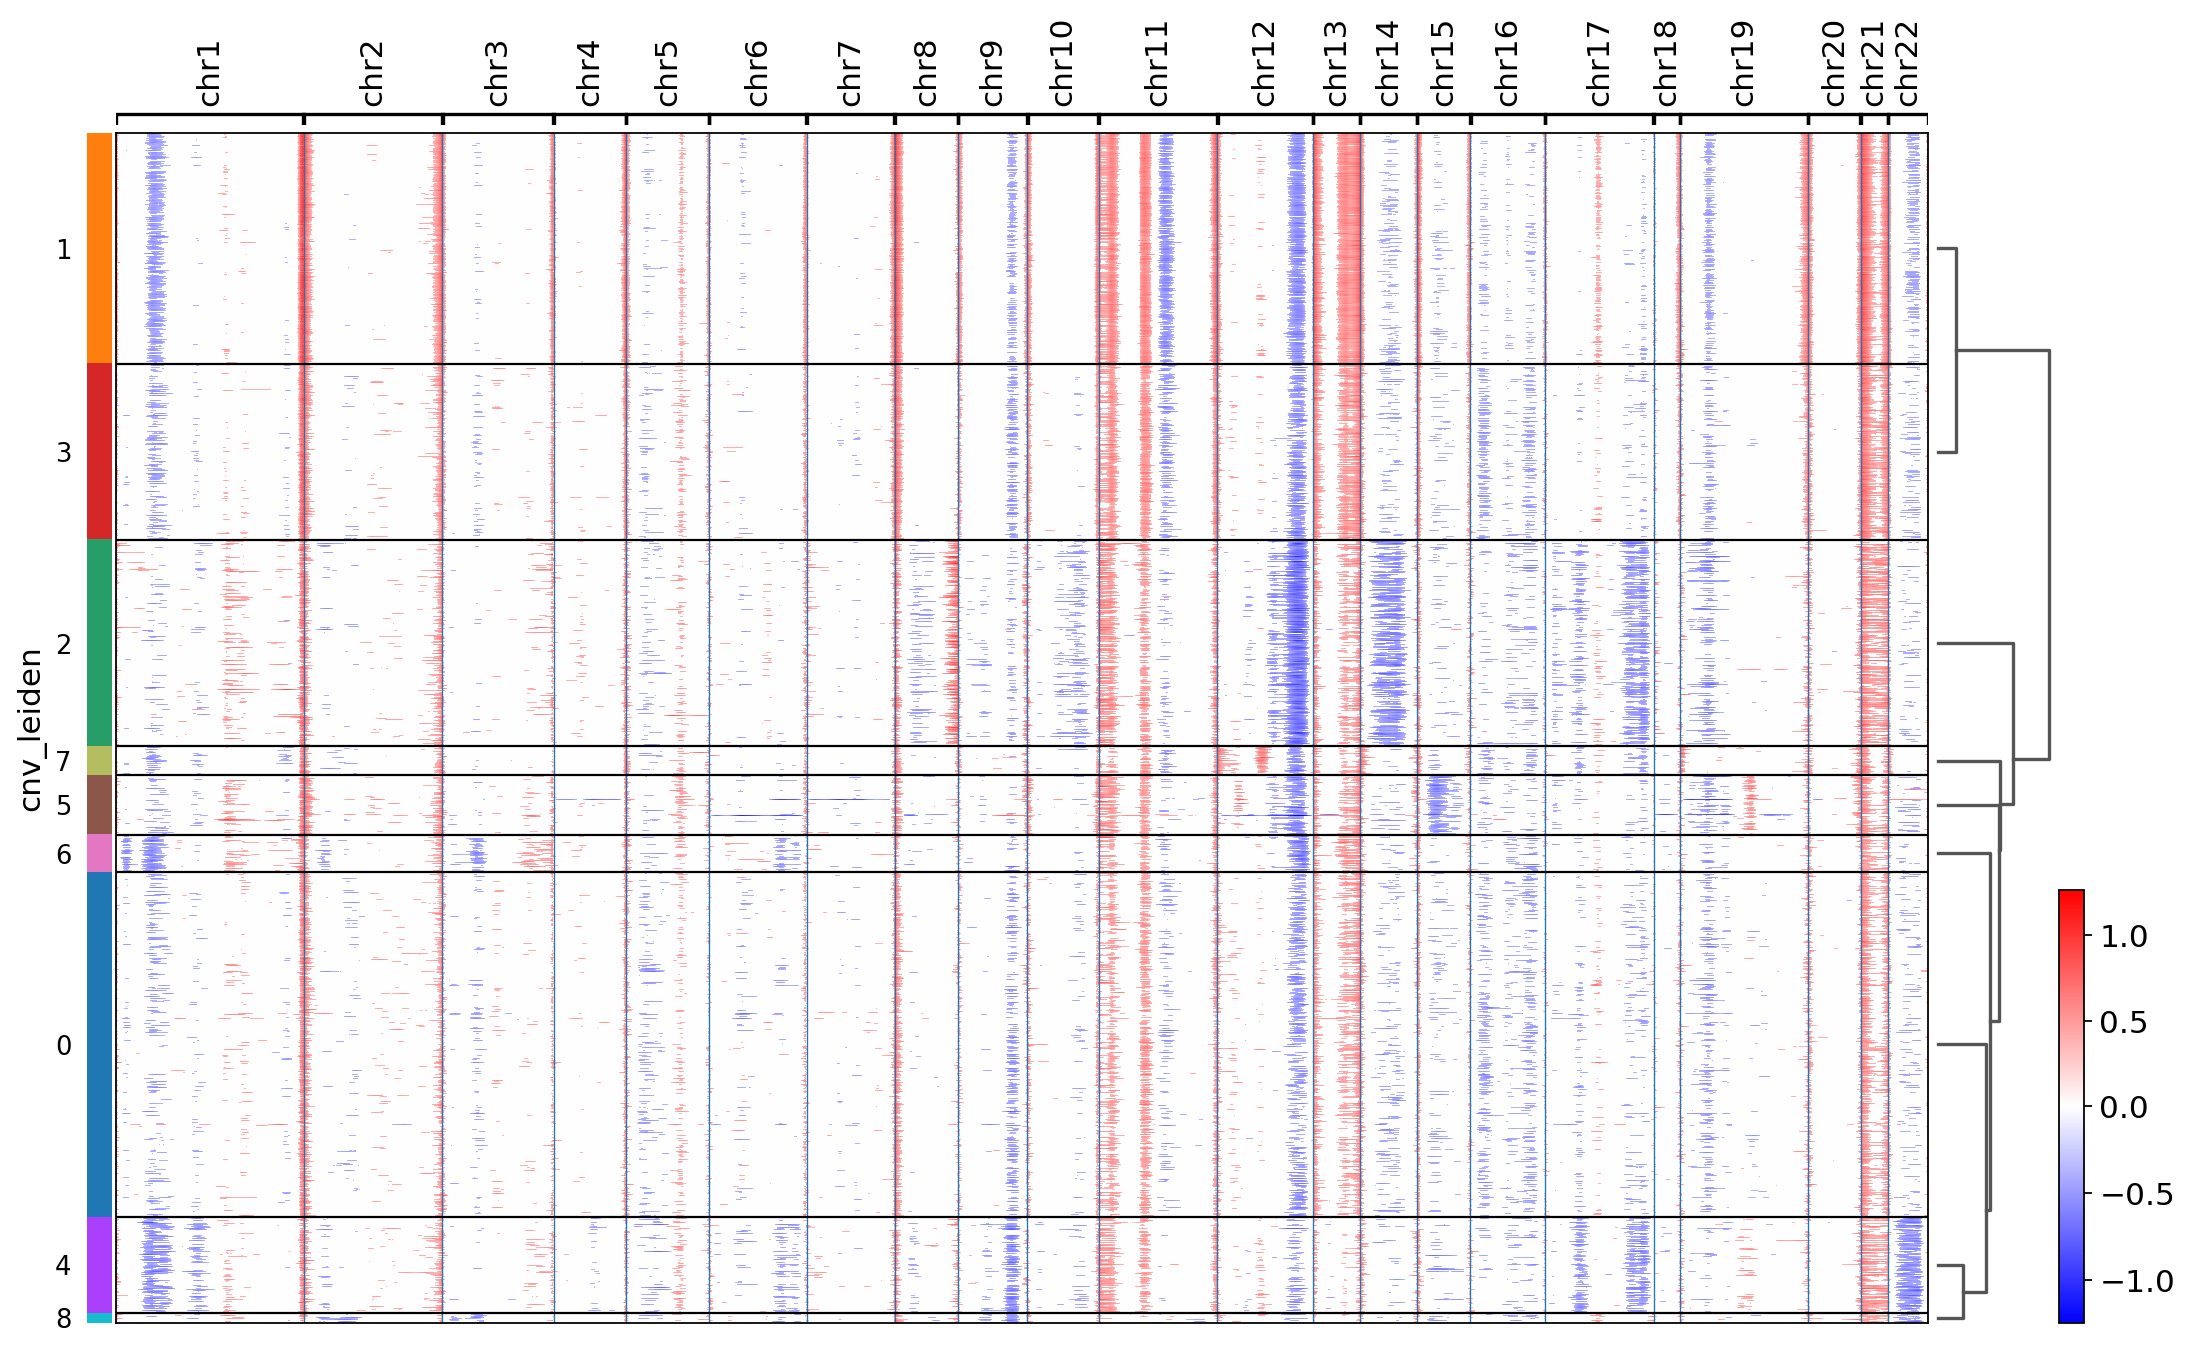

In [24]:
cnv.pl.chromosome_heatmap(adata_t, groupby="cnv_leiden", dendrogram=True)

# UMAP of CNV profiles - Epithelial cell

... storing 'cnv_status' as categorical


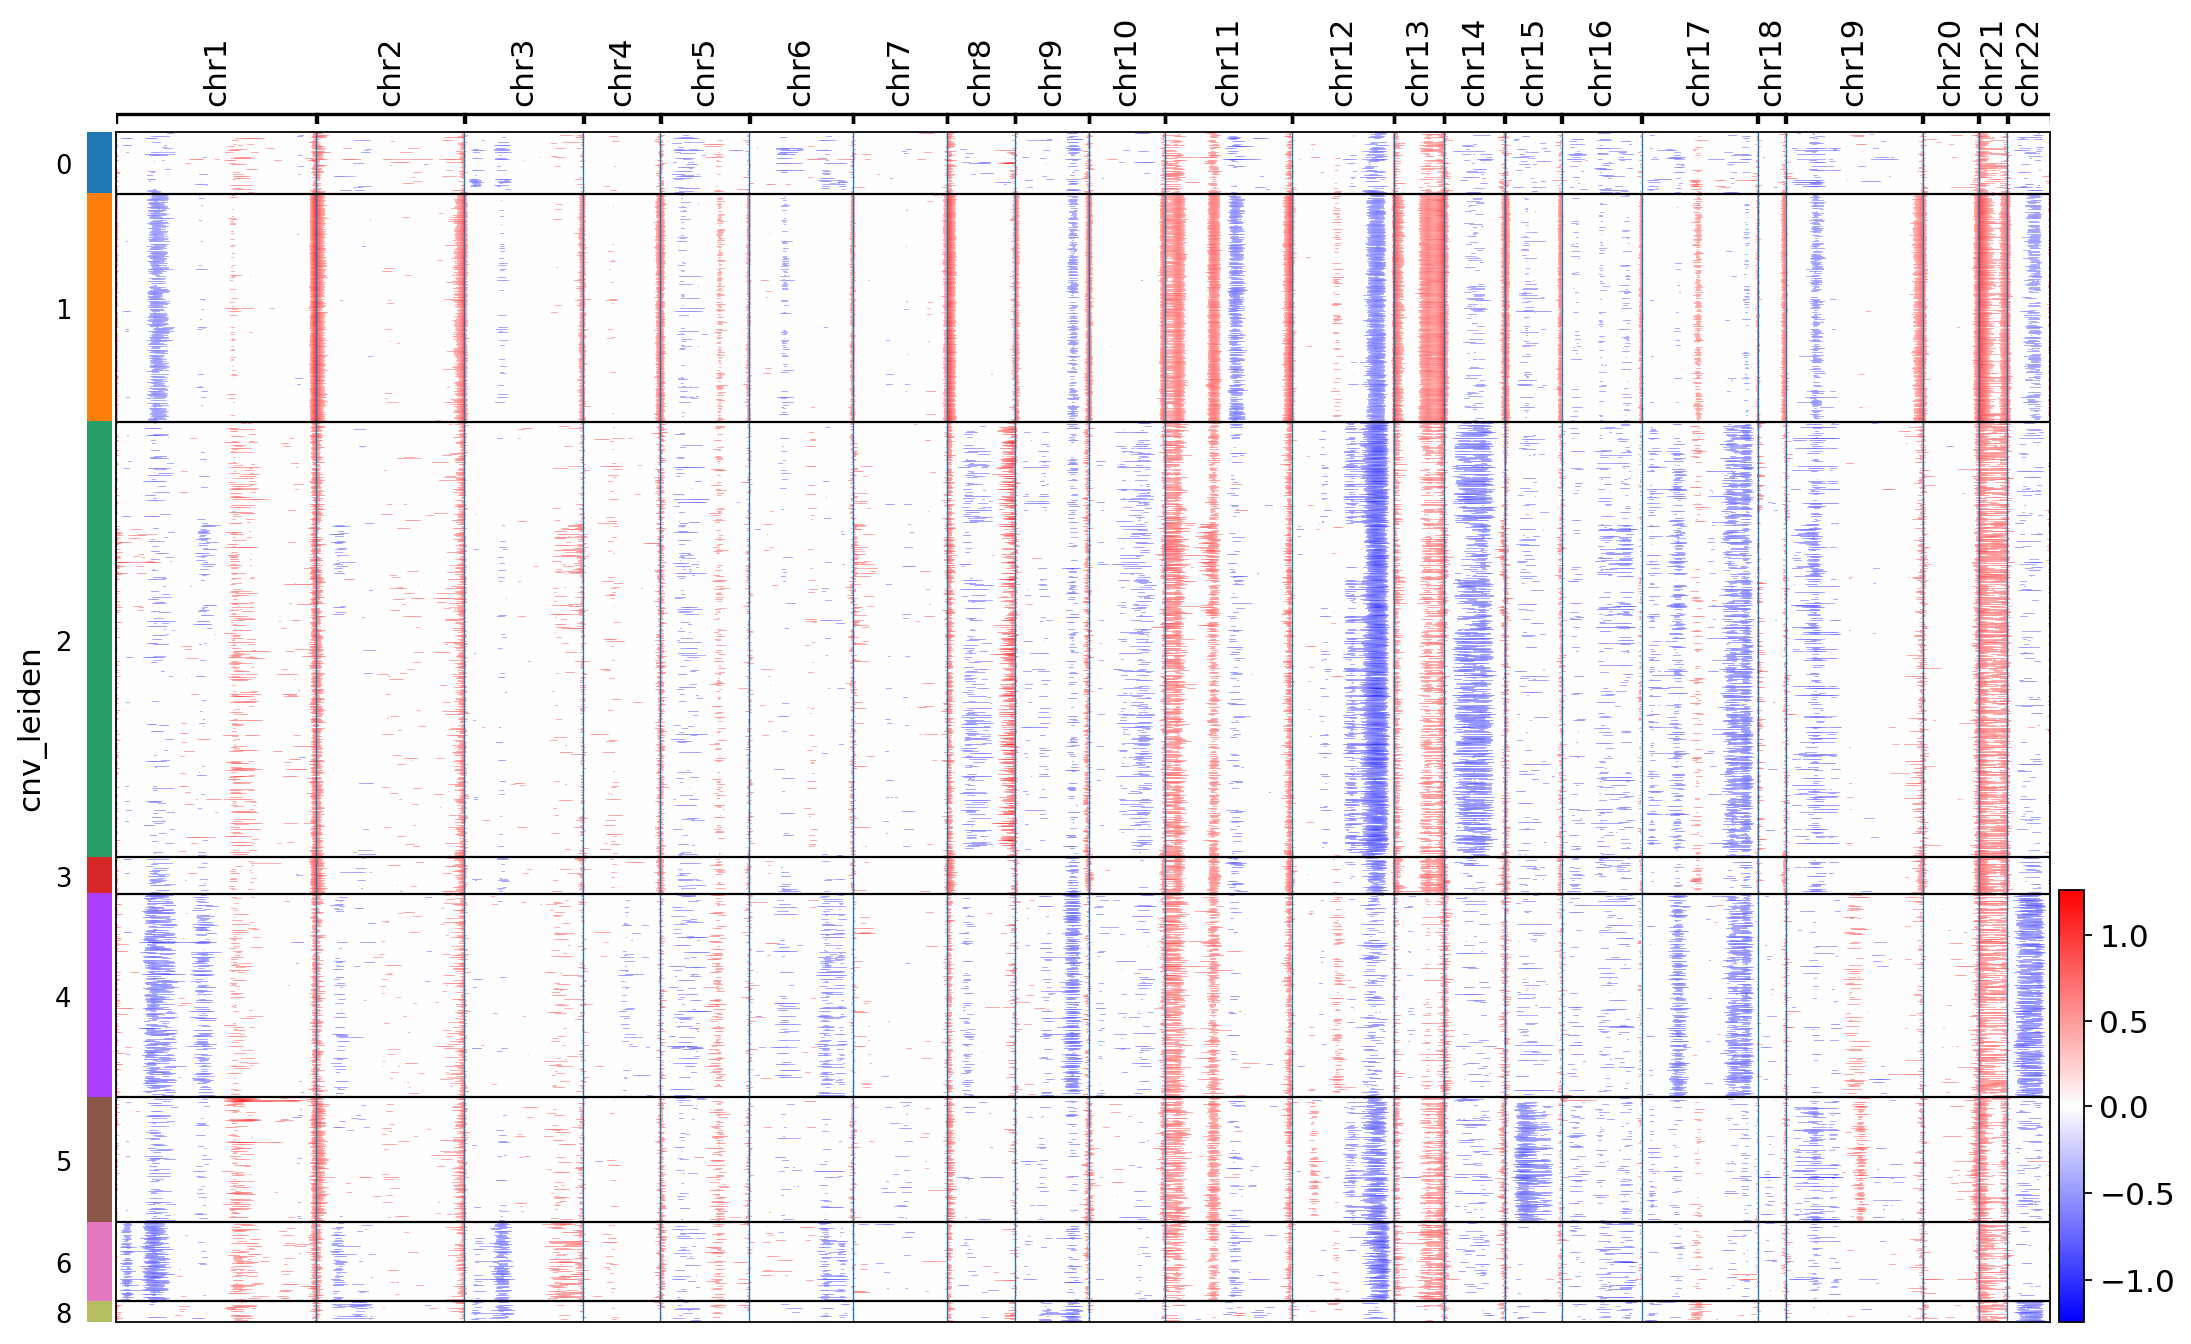

In [33]:
m = adata_t.obs['cell_type_major_pred'] == 'Epithelial cell'
adata_t_sel = adata_t[m]
cnv.pl.chromosome_heatmap(adata_t_sel, groupby="cnv_leiden")

In [27]:
cnv.tl.umap(adata_t)
cnv.tl.cnv_score(adata_t)

... storing 'chromosome' as categorical
... storing 'gene_id' as categorical
... storing 'gene_name' as categorical


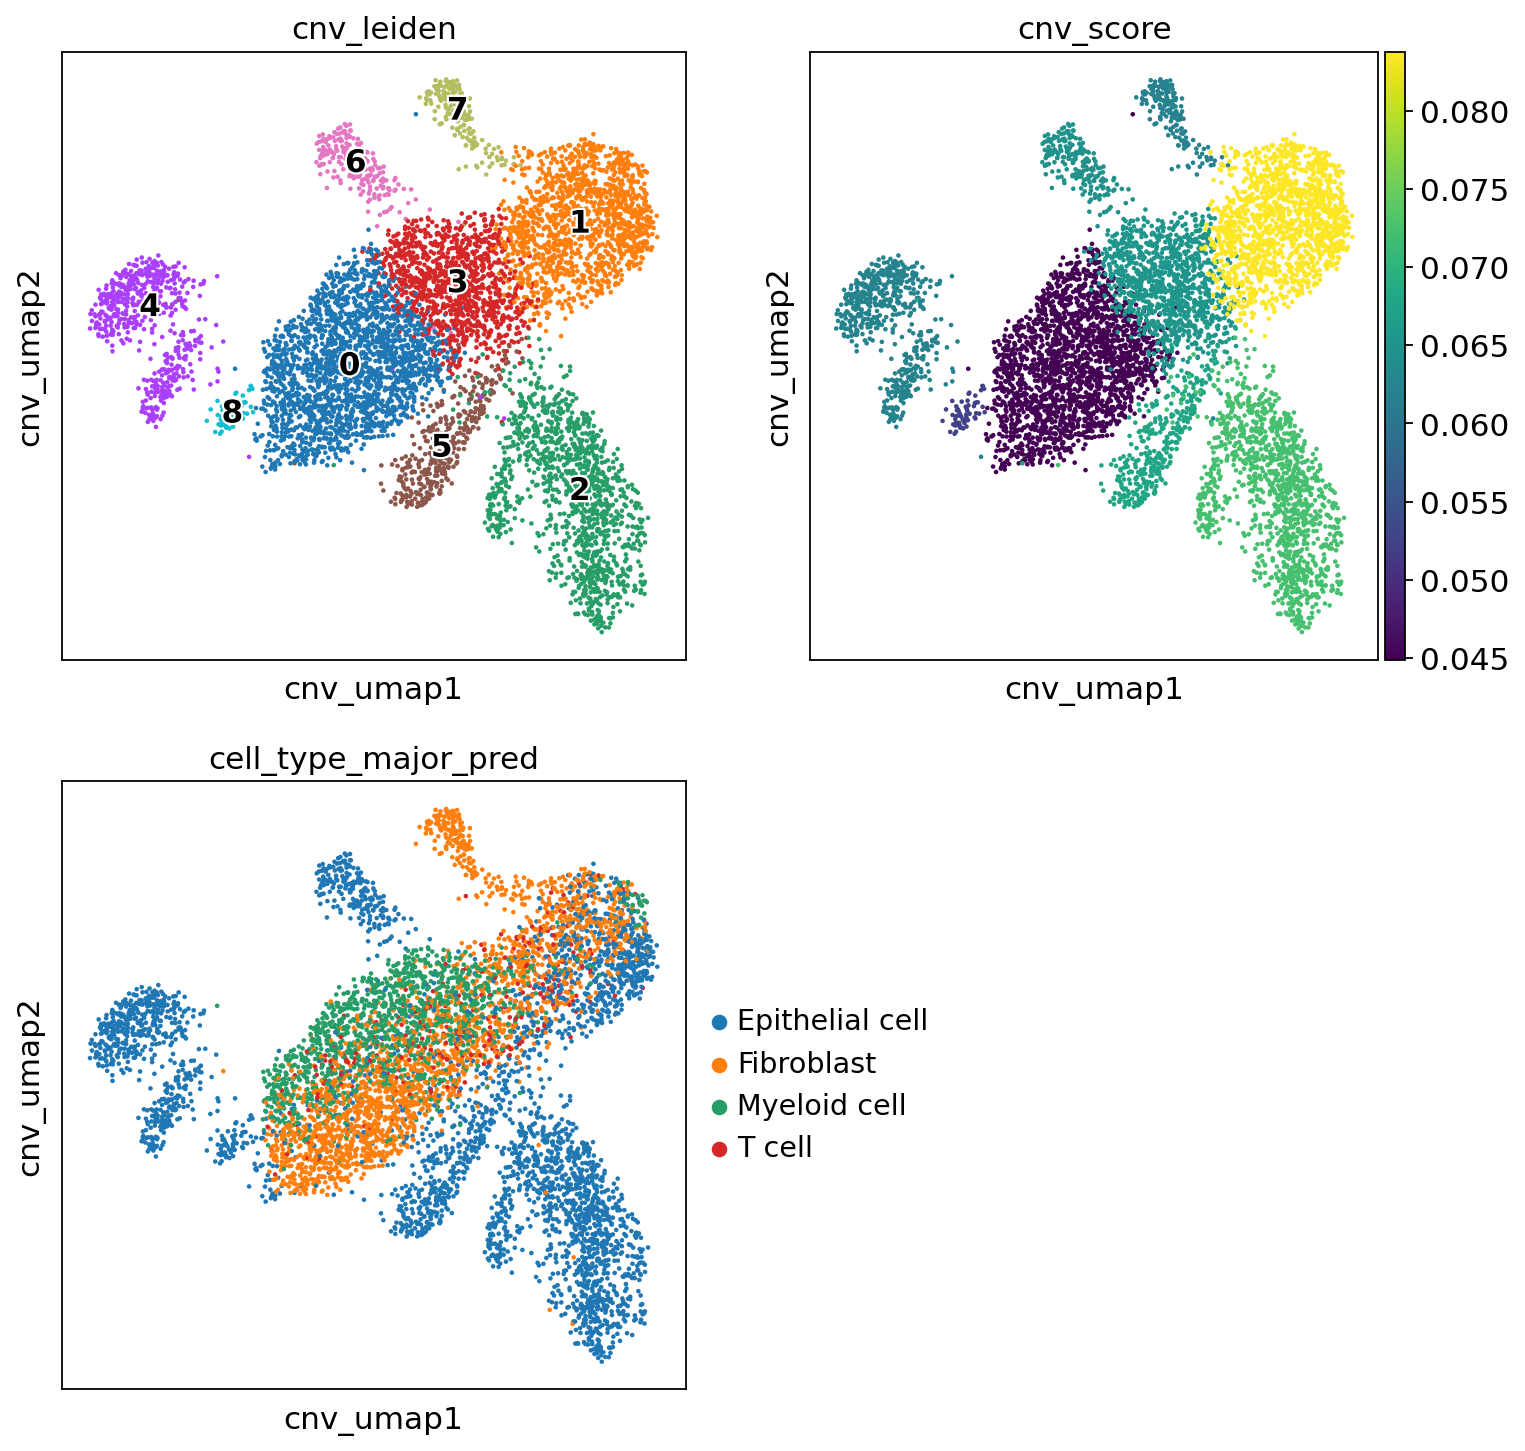

In [28]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(11, 11))
ax4.axis("off")
cnv.pl.umap(
    adata_t,
    color="cnv_leiden",
    legend_loc="on data",
    legend_fontoutline=2,
    ax=ax1,
    show=False,
)
cnv.pl.umap(adata_t, color="cnv_score", ax=ax2, show=False)
cnv.pl.umap(adata_t, color="cell_type_major_pred", ax=ax3)

# Classifying tumor cells

In [32]:
max_cnv = adata_t.obs['cnv_score'].max()
adata_t.obs['cnv_status'] = 'normal'
m1 = adata_t.obs['cnv_score'] == max_cnv
m2 = adata_t.obs['cell_type_major_pred'] == 'Epithelial cell'
m = m1&m2
adata_t.obs.loc[m,'cnv_status'] = 'tumor'
adata_t.obs['cnv_status'].value_counts()

normal    6395
tumor      636
Name: cnv_status, dtype: int64

In [40]:
adata.obs = adata_t.obs
adata.write(save_file)

... storing 'cnv_status' as categorical


# Visualization

In [45]:
color_dict = dict()
color_dict['Epithelial cell']='#de3f3a'
color_dict['Fibroblast']='#dece3a'
color_dict['Endothelial cell']='#3ade50'
color_dict['T cell']='#3ad0de'
color_dict['Myeloid cell']='#453ade'
color_dict['Stellate cell']='#9536a3'
color_dict['B cell']='#36a398'
color_dict['Acinar cell']='#c28d2b'
color_dict['Mast cell']='#a2a1ad'
color_dict['unassigned']='#ec03fc'

In [54]:
file_dir = '/mnt/HDD1/Work_Paper/Singlecell_RNA/PreProcessed_GSE154778/Ann_GSE154778.h5ad'
#file_dir = save_file
adata = sc.read_h5ad(file_dir)
#sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
n_top_genes = 6000
n_neighbors = 15
N_pca = 30

sc.pp.highly_variable_genes(adata,n_top_genes=n_top_genes)
adata_HVG = adata[:,adata.var.highly_variable]
sc.tl.pca(adata_HVG, svd_solver='arpack', n_comps = N_pca)
sc.pp.neighbors(adata_HVG, n_neighbors=n_neighbors, n_pcs=N_pca)

sc.settings.set_figure_params(dpi=100, figsize=(5,5), fontsize=18)
sc.tl.umap(adata_HVG)


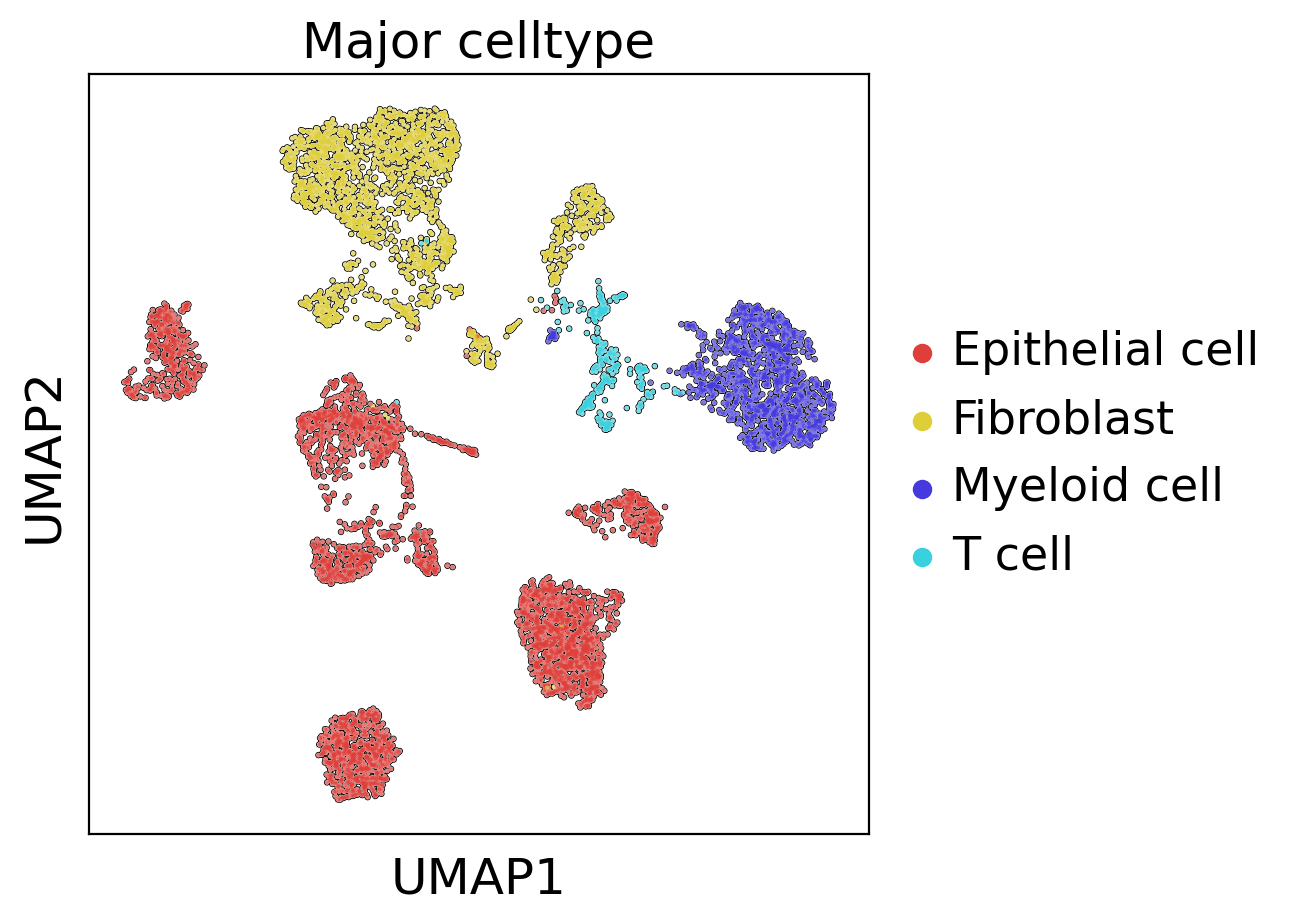

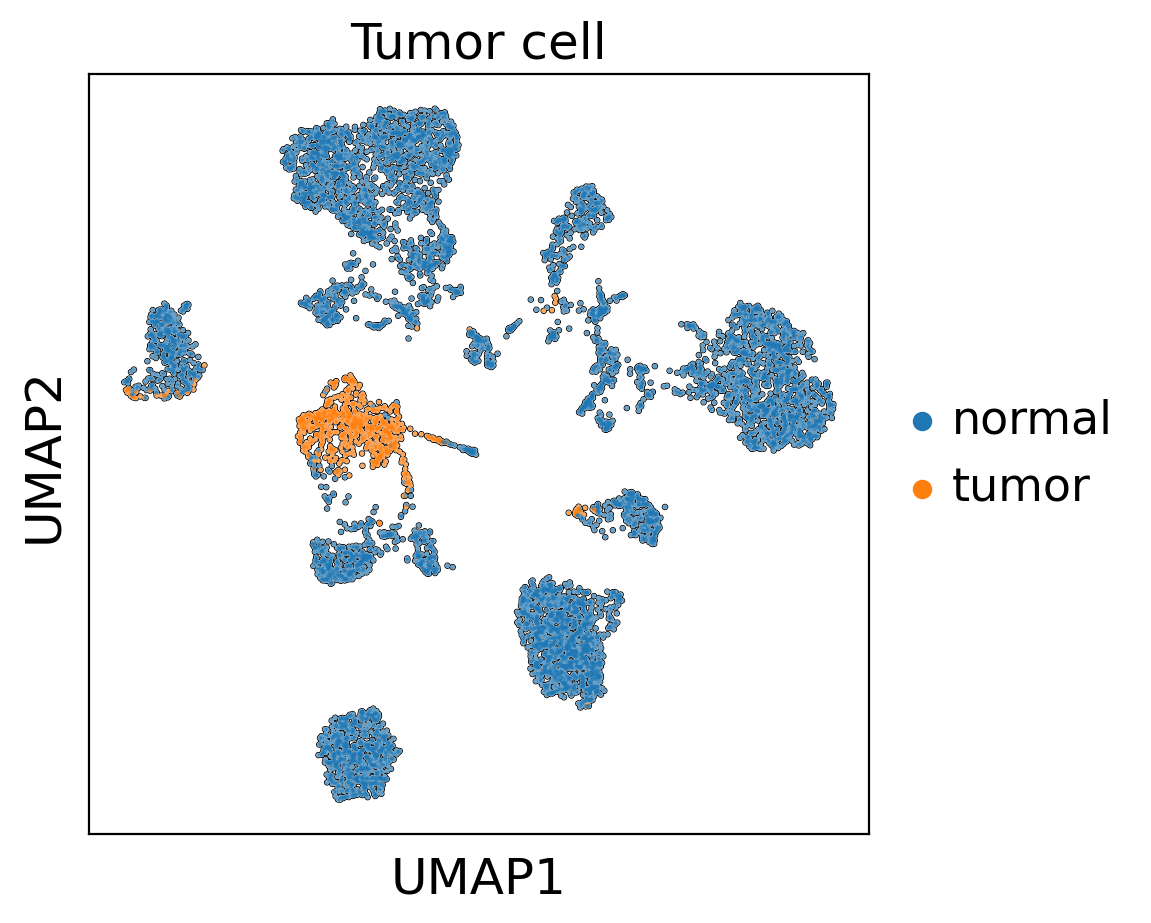

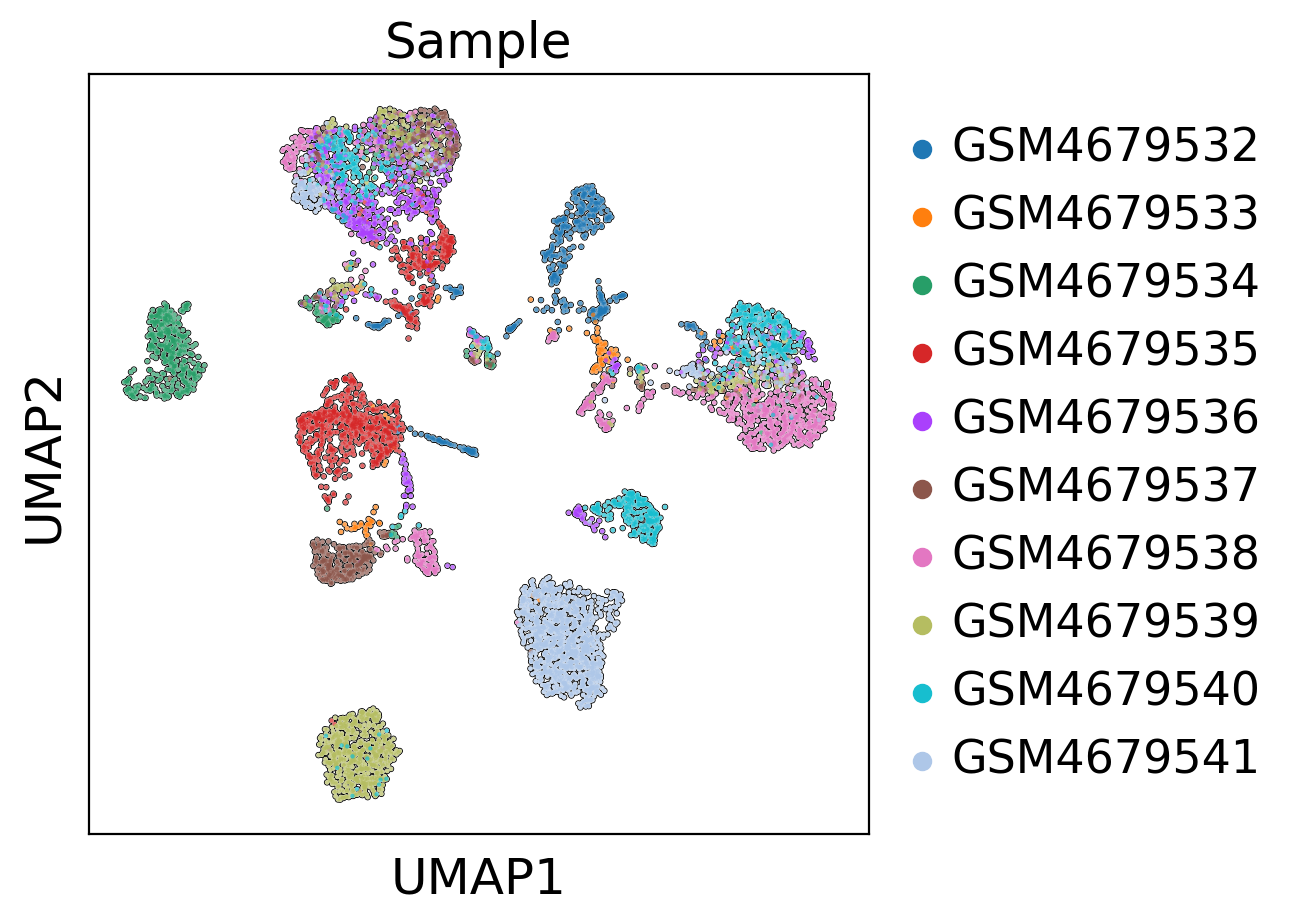

In [55]:
sc.pl.umap(adata_HVG, color=['cell_type_major_pred'], s=10, wspace=0.4, title='Major celltype', palette=color_dict, add_outline=True, outline_width=(0.2, 0.03))
sc.pl.umap(adata_HVG, color=['cnv_status'], s=10, wspace=0.4, title='Tumor cell', add_outline=True, outline_width=(0.2, 0.03))
sc.pl.umap(adata_HVG, color=['SampleID'], s=10, wspace=0.4, title='Sample', add_outline=True, outline_width=(0.2, 0.03))

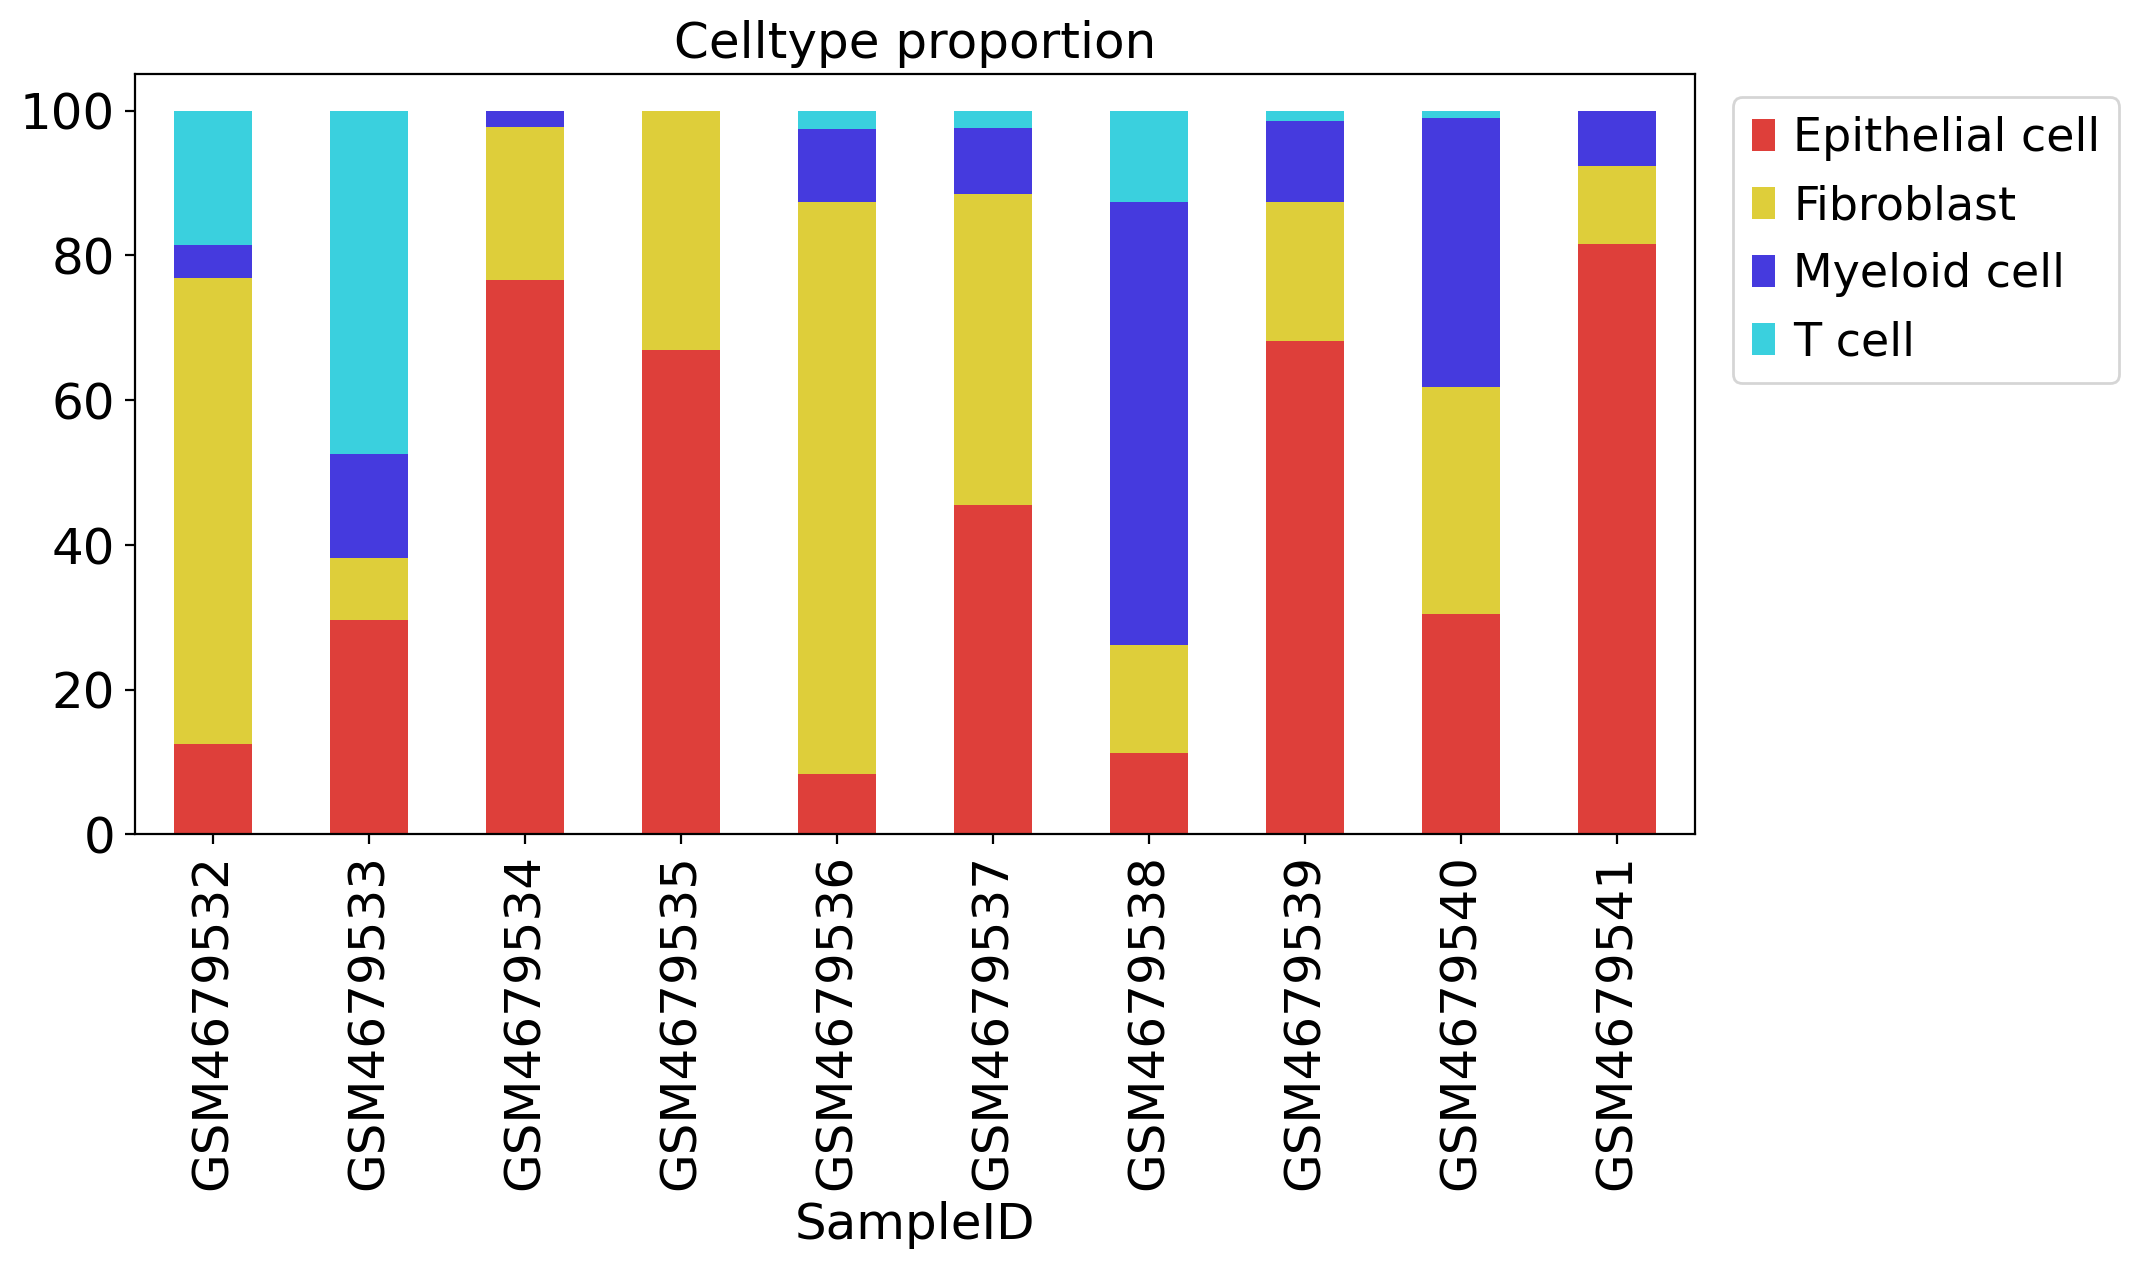

In [80]:
sc.settings.set_figure_params(dpi=100, figsize=(10,5), fontsize=18)
g = adata_HVG.obs.groupby('SampleID')['cell_type_major_pred'].value_counts().to_frame()
g.columns = ['counts']
g = g.reset_index(level=1)
g = pd.pivot_table(g, values='counts',index=g.index, columns='cell_type_major_pred')
g_pct = g.div(g.sum(axis=1), axis=0)*100
g_pct['SampleID'] = list(g_pct.index)
ax = g_pct.plot(x='SampleID', kind='bar', stacked=True, color=[color_dict.get(x, '#333333') for x in g_pct.columns])
ax.legend(bbox_to_anchor=(1.01,1))
plt.grid(False)
plt.title('Celltype proportion')
plt.xticks(rotation=90)
plt.show()